In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Part of my code is based off of Rodney Osodo's variational quantum classifier project for QOSF (https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2) and the Qiskit implementatin of it (https://learn.qiskit.org/course/machine-learning/variational-classification). Any code segments that I used from either of these two sources will be marked with a tilde (~). 

# Additional imports

In [2]:
#imports
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Import data

In [3]:
def normalizeData():
    #Normalizes the data
    RANDOM_STATE = 42
    
    # Reads the data
    data_train = pd.read_csv("../QOSF Mentorship - March 2022/mock_train_set.csv")
    data_train = shuffle(data_train, random_state=RANDOM_STATE)
    X_train, Y_train = data_train[['0', '1', '2', '3']].values, data_train['4'].values
    
    data_test = pd.read_csv("../QOSF Mentorship - March 2022/mock_test_set.csv")
    data_test = shuffle(data_test, random_state=RANDOM_STATE)
    X_test, Y_test = data_test[['0', '1', '2', '3']].values, data_test['4'].values
        
    # normalize the data
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    
    return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = normalizeData()

# Encode data

In [5]:
# constant for the number of qubits 
n = X_train.shape[1]

In [6]:
sv = Statevector.from_label('0' * n)

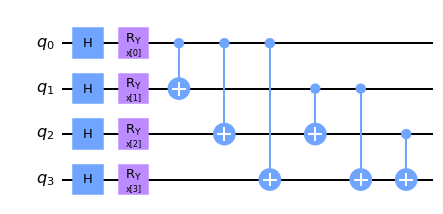

In [7]:
# Feature Map set-up

feature_map = QuantumCircuit(n)

X_list = ParameterVector('x', length=n)

for i in range(n):
    feature_map.h(i)
    feature_map.ry(X_list[i], i)
    
for i in range(n):
    for j in range(n - i - 1):
        feature_map.cx(i, j + i + 1)

feature_map.draw()

# Variational circuit

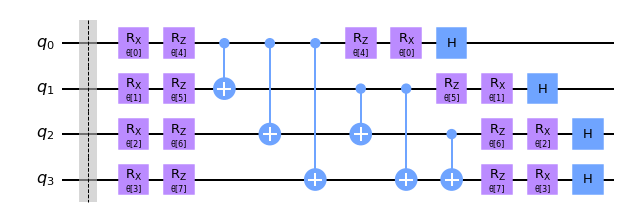

In [8]:
var_form = QuantumCircuit(n)

theta_list = ParameterVector('θ', length=n*2)

var_form.barrier();

for i in range(n):
    var_form.rx(theta_list[i], i)
    var_form.rz(theta_list[i+4], i)
    
for i in range(n - 1):
    for j in range(n- i - 1): #full entanglement
        var_form.cx(i, j + i + 1) 
    
for i in range(n):
    var_form.rz(theta_list[i+4], i)
    var_form.rx(theta_list[i], i)
    var_form.h(i)


var_form.draw()

In [9]:
circuit = feature_map.combine(var_form)

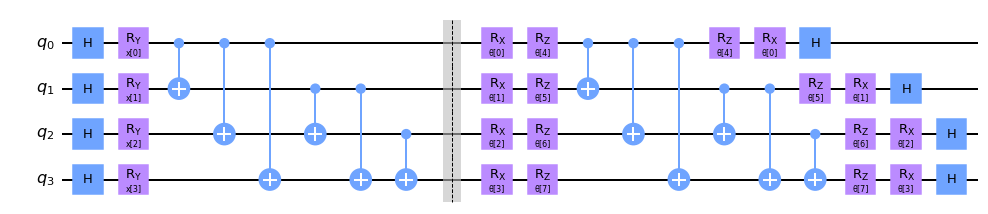

In [10]:
circuit.draw()

# Parity checker

In [11]:
def parity_check(bit_string):
    parity = 0
    for i in range(len(bit_string)):
        parity += int(bit_string[i])
    parity = parity % 2
    if parity:
        return 1
    else:
        return 0

# Cost function

In [12]:
# ~
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(X_list):
        parameters[p] = x[i]
    for i, p in enumerate(theta_list):
        parameters[p] = params[i]
        
    return parameters

In [13]:
# ~
def return_probabilities(counts):
    shots = sum(counts.values())
    result = {0: 0,
    1: 0}
    for key, item in counts.items():
        result[parity_check(key)] += counts[key]/shots
    return result

In [14]:
# ~
def classify(x_list, params):
    qc_list = []
    for x in x_list:
        circ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()        
        prob = return_probabilities(counts)
        probs += [prob]
    return probs

In [15]:
# ~
def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [16]:
# ~
cost_list = []
def cost_function(X, Y, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [0]
        elif label == 1:
            training_labels += [1]
    probs = classify(training_samples, params)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

# Run circuit

In [17]:
# ~
cost_list = []
optimizer = SPSA(maxiter=100)

# define objective function for training
objective_function = lambda params: cost_function(X_train, Y_train, params, print_value=True)
# randomly initialize the parameters
np.random.seed(42)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('cost: ', value)

0.2661
0.3485
0.2796
0.3214
0.3214
0.2795
0.2903
0.3350
0.2972
0.2972
0.3070
0.3008
0.2813
0.3313
0.3339
0.2869
0.3528
0.2736
0.2697
0.3582
0.3020
0.2994
0.3350
0.2903
0.2661
0.3485
0.2767
0.3086
0.3207
0.2795
0.3070
0.3008
0.3304
0.2788
0.3025
0.3153
0.3129
0.2836
0.3005
0.3040
0.3577
0.2712
0.3057
0.2768
0.2941
0.2905
0.2967
0.2973
0.2948
0.3042
0.2806
0.3405
0.2621
0.2549
0.2661
0.2504
0.2552
0.2387
0.2547
0.2260
0.2128
0.2348
0.2255
0.2064
0.2201
0.2160
0.2288
0.1932
0.2032
0.2052
0.1970
0.1966
0.2188
0.1970
0.2118
0.1855
0.2002
0.1994
0.1801
0.1999
0.1948
0.1855
0.1905
0.1902
0.1858
0.1960
0.1894
0.1817
0.1876
0.1824
0.1911
0.1872
0.1837
0.1860
0.1945
0.1720
0.1704
0.1980
0.1780
0.1689
0.1838
0.1748
0.1662
0.1766
0.1717
0.1821
0.1815
0.1687
0.1748
0.1657
0.1618
0.1785
0.1734
0.1685
0.1744
0.1634
0.1734
0.1756
0.1706
0.1726
0.1654
0.1695
0.1753
0.1689
0.1727
0.1554
0.1632
0.1730
0.1722
0.1716
0.1586
0.1704
0.1599
0.1601
0.1672
0.1684
0.1706
0.1605
0.1620
0.1662
0.1646
0.1621
0.1645

# Test circuit

In [22]:
# ~
def test_model(X, Y, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params)
    for i, prob in enumerate(probs):
        # checks if the probability of the right answer is higher than the wrong answer
        if (prob.get(Y_test[i]) >= prob.get((Y_test[i] + 1) % 2)): 
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

In [23]:
# ~
test_model(X_test, Y_test, opt_params)

Test accuracy: 1.0



<built-in method count of list object at 0x7fc72378b1c0>


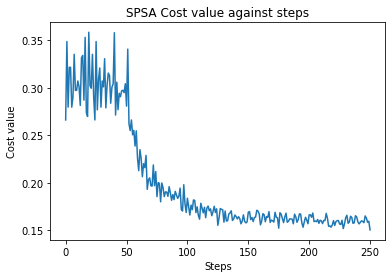

In [24]:
# ~
fig = plt.figure()
print(cost_list.count)
plt.plot(range(0,len(cost_list),1), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("SPSA Cost value against steps")
plt.show()